# Predict household poverty from satellite imagery data

Using code from run_grid.py, adjust the process to include feature extraction using CNN and changing target to poverty levels.
***
**ML pipeline steps in detail here:**  
1. Import and prep data  
    - Import BISP data  
    - Choose transformation for target variable (poverty)  
    - Import NTL (viirs) data  
    - Match BISP HHs to coordinates  
    - Join Bisp data and NTL data  
    - Map DTL image files to data  
<br>
2. Use CNN to extract features from DTL  
    - Prep DTL, load CNN, and extract features  
    - Select extracted features to include using PCA  
    - Add selected extracted features to data   
<br>
3. Split data into test/train sets  
***
**ML pipline steps handled by run_grid.py:** 
4. Train and evaluate models (run grid search). For each regressor-hyperparameter combination:  
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels

In [15]:
import os
import math
import pickle
import numpy as np
import pandas as pd 
import geopandas as gpd

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Specify autoreload
%load_ext autoreload
%autoreload 2

# Import configuration file and feature extraction file
import config as cf
import feature_extraction as fe

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1 

# Data file path 
# final_data_file_path = "/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites/Data/FinalData"

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import data and prep data

### 1.1 Import BISP data

In [32]:
#### Predict Changes
# DATA_PATH = os.path.join(final_data_file_path, 'BISP','Merged Datasets', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')
# DATA_PATH = os.path.join('/Users/robmarty/Desktop/', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')

#### Predict Levels
DATA_PATH = os.path.join('BISP', 'bisp_socioeconomic_satellite_panel_full_satPovNAsRemoved_1hh.csv')

df = pd.read_csv(DATA_PATH)
df.shape

(4528, 502)

In [33]:
# Restrict to Year
df = df[df['year'] == 2014]
df.shape

(3273, 502)

### 1.2 Choose transformation for target (poverty)

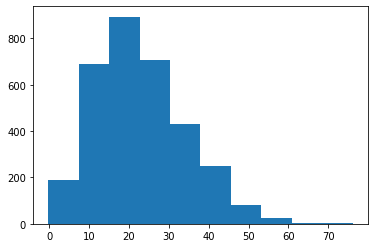

In [19]:
# Look at distribution
plt.hist(df['pscores']);

In [34]:
### Changes
#df['pscores_bin'] = df['pscores'] < 0

#### Levels
#df = df.loc[df['survey_round'] != 1]
#df['pscores_bin'] = df['pscores'] <= (df['pscores'].median())
#df['pscores_bin'] = df['pscores_poor']

### Target as Quantiles
#df['pscores_bin'] = pd.qcut(df['pscores'], 4, labels=False)
#df['pscores_2011'].value_counts()
#df['pscores_bin'] = df['pscores'] < 0

### Clustered by K-Means
#pscores = df['pscores'].to_numpy().reshape(-1,1)
#discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
#df['pscores_bin'] = discretizer.fit_transform(pscores)

### Binary
df['in_poverty'] = (df['pscores']<=16.17)
df['in_poverty'] = df['in_poverty'].astype(int)

df.in_poverty.value_counts()

0    2248
1    1025
Name: in_poverty, dtype: int64

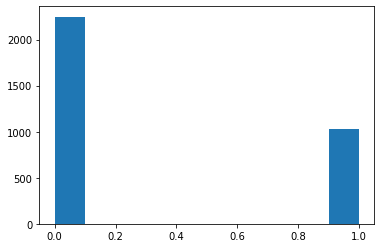

In [36]:
plt.hist(df['in_poverty']);

### 1.3 Import NTL data

In [236]:
# Load satellite data
viirs_gdf = gpd.read_file('satellite_raw/VIIRS/viirs_annual_polygon.geojson')
viirs_gdf = viirs_gdf[['median_rad_2014', 'tile_id', 'geometry']]
viirs_gdf.head(2)

,median_rad_2014,tile_id,geometry
0,0.179258,42.0,"POLYGON ((74.66347 37.06224, 74.67021 37.06224, 74.67021 37.05551, 74.66347 37.05551, 74.66347 37.06224))"
1,0.207353,42.0,"POLYGON ((74.67021 37.06224, 74.67695 37.06224, 74.67695 37.05551, 74.67021 37.05551, 74.67021 37.06224))"


### 1.4 Match BISP HHs to Coordinates

In [40]:
# Load BISP coordinate info
coords = pd.read_stata('BISP/GPS_uid_crosswalk.dta')

from math import floor
def get_lat_lon(number):
    deg = floor(number / 100)
    min = floor(number - (100 * deg))
    sec = 100 * (number - (100 * deg) - min)
    degree = deg + (min / 60) + (sec / 3600)
    return degree

# Drop NAs
coords = coords[~coords['GPSN'].isna()]

# Get lat, lon
coords['lat'] = coords['GPSN'].apply(lambda x: get_lat_lon(x))
coords['lon'] = coords['GPSE'].apply(lambda x: get_lat_lon(x))

# Convert uid to integer
coords['uid'] = coords['uid'].astype(int)

# Create geopandas
coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords['lon'], coords['lat']))
coords.head()

,GPSN,GPSE,uid,lat,lon,geometry
0,3349.405,7241.680,104989,33.827917,72.702222,POINT (72.70222 33.82792)
1,3349.403,7241.698,100389,33.827861,72.702722,POINT (72.70272 33.82786)
2,3349.392,7241.730,101236,33.827556,72.703611,POINT (72.70361 33.82756)
3,3349.383,7241.486,105557,33.827306,72.696833,POINT (72.69683 33.82731)
4,3349.370,7241.639,101915,33.826944,72.701083,POINT (72.70108 33.82694)


In [41]:
# Match coords to HHs in df
gdf_bisp = coords.merge(df, left_on='uid', right_on='uid')
gdf_bisp.shape

(3273, 508)

### 1.5 Join Bisp data and NTL data
Bisp HHs located in an NTL tile/poly are linked to that NTL radiance value 

In [42]:
# Spatial join HHs with satellite viirs
gdf = gpd.sjoin(viirs_gdf, gdf_bisp, how="inner", op='intersects').reset_index(drop=True)
# Reset index because multiple HHs may belong to one NTL tile

In [54]:
# Inspect range of tiles represented
print(gdf.shape)
print(sorted(gdf['tile_id'].unique()))

(3259, 511)
[1.0, 2.0, 8.0, 9.0, 10.0, 13.0, 14.0, 15.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 36.0, 37.0, 38.0, 40.0]


### 1.6 Map DTL image files to data

In [63]:
DTL_directory = os.path.join('satellite_raw', 'Landsat', '2014')
DLT, processed_gdf = fe.map_DTL_NTL(gdf, DTL_directory)

In [64]:
print(processed_gdf.shape)
print('Note: {} observations were dropped due to irregular DTL sizes'.format(gdf.shape[0] - processed_gdf.shape[0]))

(3259, 511)
Note: 0 observations were dropped due to irregular DTL sizes


In [65]:
# Feature Columns
df_viirs = processed_gdf.filter(regex='viirs').filter(regex='_2km')
df_landsat = processed_gdf.filter(regex='^b').filter(regex='_1km')
df_osm = processed_gdf.filter(regex='fclass').filter(regex='meters')
df_facebook = processed_gdf.filter(regex='^estimate_dau')

# Target Column
df_y = processed_gdf[['pscores', 'in_poverty']]

# Final df
df_final = df_y.join(df_osm).join(df_facebook).join(df_landsat).join(df_viirs).reset_index(drop=True)

# 2. Use CNN to extract features from DTL

### 2.1 Prep DTL, load CNN, and extract features

In [66]:
# Reshape DTL like in CNN training
height, width, channels = 25, 26, 7
DLT = DLT.reshape((DLT.shape[0], height, width, channels))
print('DTL after reshaping: {}'.format(DLT.shape))

DTL after reshaping: (3259, 25, 26, 7)


In [59]:
### Save objects for later
#processed_gdf.to_pickle('saved_objects/processed_gdf.pkl')
#df_final.to_pickle('saved_objects/df_final.pkl')
#np.save('saved_objects/poverty_DLT', DLT)
#viirs_gdf.to_pickle('saved_objects/viirs_gdf.pkl')

### Restart here
processed_gdf = pd.read_pickle('saved_objects/processed_gdf.pkl')
df_final = pd.read_pickle('saved_objects/df_final.pkl') #target = binary
DLT = np.load('saved_objects/poverty_DLT.npy')
viirs_gdf = pd.read_pickle('saved_objects/viirs_gdf.pkl')

In [60]:
# Load CNN
from keras.models import load_model
model = load_model('best_CNN.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 21, 22, 64)        11264     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 11, 64)        0         
_________________________________________________________________
flatten1 (Flatten)           (None, 7040)              0         
_________________________________________________________________
dense1 (Dense)               (None, 100)               704100    
_________________________________________________________________
dense2 (Dense)               (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Extract features
df_features = fe.extract_features(model, DLT, 'dense1')
df_features

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,0.0,0.0,0.0,2078.216797,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1697.983398,0.0,0.0,0.000000,1473.291626,826.142334,0.0,0.0,0.0,0.0,876.303772,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,593.273987,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2454.766357,0.0,3466.903809,550.257568,0.00000,0.0,0.0,0.000000,704.017395,713.016357,1698.519409,0.000000,0.000000,809.686218,0.0,0.0,1858.261230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5320.941406,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2154.061523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,375.566833,880.228943,0.0,1721.483398
1,0.0,0.0,0.0,0.000000,77.971481,227.652298,494.634735,0.0,0.0,0.0,0.0,15.366259,111.620102,0.000000,0.0,0.0,0.000000,1376.690674,1178.718140,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,532.434631,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4.344375,0.0,172.028961,0.000000,481.96524,0.0,0.0,95.996819,955.976501,0.000000,384.538727,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663.467529,0.0,0.0,0.0,0.0,0.0,3115.863281,0.000000,0.0,0.0,0.0,0.000000,534.530518,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.063496,0.0,0.0,515.100342,0.000000,0.000000,0.0,448.425934
2,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,43.338295,0.000000,0.0,0.0,0.0,0.0,7.767977,0.000000,0.000000,0.0,0.0,0.000000,116.873428,164.494888,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.511365,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,140.947861,0.000000,0.000000,239.845703,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.422516,0.0,0.0,0.0,0.0,0.0,1223.804932,0.000000,0.0,0.0,0.0,0.000000,137.153534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,360.021118,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### 2.2 Select extracted features to include using PCA

In [68]:
pca = PCA(n_components=10)
pca.fit(df_features)
print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))

features_pca = pca.transform(df_features)
column_names = ['pc_%01d' %i for i in range(0,10)]
df_features_pca = pd.DataFrame(data=features_pca, columns=column_names)
df_features_pca

Explained variance ratio: [0.51215154 0.21327281 0.05961568 0.04426583 0.03543014 0.02348132
 0.01775924 0.01621351 0.00987017 0.00955148]


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,5616.054199,4190.888184,1276.716797,-631.960938,2329.995605,-1627.397217,-1267.530640,1452.524780,1694.799683,960.588745
1,3082.897705,1248.507080,-8.314354,797.964600,-366.158966,-1152.810913,341.082245,-219.035812,199.352036,-975.409180
2,2013.003662,-667.683289,-66.913170,51.946175,79.527023,-216.621109,353.959747,-72.776970,290.633972,-216.248520
3,2013.003662,-667.683289,-66.913170,51.946175,79.527023,-216.621109,353.959747,-72.776970,290.633972,-216.248520
4,2013.003662,-667.683289,-66.913170,51.946175,79.527023,-216.621109,353.959747,-72.776970,290.633972,-216.248520
...,...,...,...,...,...,...,...,...,...,...
3254,1569.887085,-823.250366,-274.187012,39.882236,30.300888,230.218079,208.682877,248.542328,189.671600,-222.494324
3255,1569.887085,-823.250366,-274.187012,39.882236,30.300888,230.218079,208.682877,248.542328,189.671600,-222.494324
3256,1569.887085,-823.250366,-274.187012,39.882236,30.300888,230.218079,208.682877,248.542328,189.671600,-222.494324
3257,2505.014893,-63.967342,-140.642685,499.150146,-432.492981,126.829231,150.644119,357.404602,365.224365,-406.085785


### 2.3 Add selected extracted features to data

In [69]:
df_final = df_final.join(df_features_pca).drop(columns=['pscores'])
df_final

,in_poverty,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,b1_buff_1km_mean,b2_buff_1km_mean,b3_buff_1km_mean,b4_buff_1km_mean,b5_buff_1km_mean,b6_buff_1km_mean,b7_buff_1km_mean,b12_buff_1km_mean,b13_buff_1km_mean,b14_buff_1km_mean,b15_buff_1km_mean,b16_buff_1km_mean,b17_buff_1km_mean,b23_buff_1km_mean,b24_buff_1km_mean,b25_buff_1km_mean,b26_buff_1km_mean,b27_buff_1km_mean,b34_buff_1km_mean,b35_buff_1km_mean,b36_buff_1km_mean,b37_buff_1km_mean,b45_buff_1km_mean,b46_buff_1km_mean,b47_buff_1km_mean,b56_buff_1km_mean,b57_buff_1km_mean,b67_buff_1km_mean,b1_buff_1km_min,b2_buff_1km_min,b3_buff_1km_min,b4_buff_1km_min,b5_buff_1km_min,b6_buff_1km_min,b7_buff_1km_min,b12_buff_1km_min,b13_buff_1km_min,b14_buff_1km_min,b15_buff_1km_min,b16_buff_1km_min,b17_buff_1km_min,b23_buff_1km_min,b24_buff_1km_min,b25_buff_1km_min,b26_buff_1km_min,b27_buff_1km_min,b34_buff_1km_min,b35_buff_1km_min,b36_buff_1km_min,b37_buff_1km_min,b45_buff_1km_min,b46_buff_1km_min,b47_buff_1km_min,b56_buff_1km_min,b57_buff_1km_min,b67_buff_1km_min,b1_buff_1km_max,b2_buff_1km_max,b3_buff_1km_max,b4_buff_1km_max,b5_buff_1km_max,b6_buff_1km_max,b7_buff_1km_max,b12_buff_1km_max,b13_buff_1km_max,b14_buff_1km_max,b15_buff_1km_max,b16_buff_1km_max,b17_buff_1km_max,b23_buff_1km_max,b24_buff_1km_max,b25_buff_1km_max,b26_buff_1km_max,b27_buff_1km_max,b34_buff_1km_max,b35_buff_1km_max,b36_buff_1km_max,b37_buff_1km_max,b45_buff_1km_max,b46_buff_1km_max,b47_buff_1km_max,b56_buff_1km_max,b57_buff_1km_max,b67_buff_1km_max,viirs_spatialmean_monthlymean_buff_2km,viirs_spatialmean_monthlysd_buff_2km,viirs_spatialmax_monthlymean_buff_2km,viirs_spatialmax_monthlysd_buff_2km,viirs_spatialmin_monthlymean_buff_2km,viirs_spatialmin_monthlysd_buff_2km,viirs_spatialsd_monthlymean_buff_2km,viirs_spatialsd_monthlysd_buff_2km,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
0,0,3792.357952,35917.095934,43.583917,13075.891660,11.621799,11474.921382,8160.699002,149159.485989,15756.970525,0,0,0,929.881663,1157.426999,1234.110660,1910.448001,1988.559096,2951.554316,1721.557358,0.109014,0.140587,0.345230,0.362754,0.520857,0.298583,0.032065,0.245454,0.264188,0.436636,0.195948,0.215082,0.234107,0.410316,0.164919,0.020034,0.214131,-0.052007,0.194934,-0.071966,-0.263207,447.0,438.0,428.0,550.0,361.5,2822.5,306.0,-0.010169,-0.021714,0.103310,-0.105751,0.726564,-0.187251,-0.011547,0.113360,-0.095685,0.731330,-0.177419,0.124744,-0.084231,0.736656,-0.166213,-0.206802,0.673832,-0.285047,0.772927,-0.083146,-0.804379,1569.0,1918.0,2235.0,3847.0,3429.0,3097.0,3625.0,0.100086,0.175079,0.420606,0.372149,0.327475,0.395841,0.076330,0.334605,0.282588,0.235095,0.307956,0.265044,0.210805,0.161665,0.237201,-0.057449,-0.108007,-0.029711,-0.050873,0.027786,0.078548,0.162807,0.096960,0.231591,0.116236,0.096512,0.084516,0.035353,0.014266,5616.054199,4190.888184,1276.716797,-631.960938,2329.995605,-1627.397217,-1267.530640,1452.524780,1694.799683,960.588745
1,1,3165.949020,36611.060520,4.980330,12488.112391,87.400393,11824.485331,7700.984802,148553.674436,15796.078642,0,0,0,870.252968,1087.029250,1152.895453,2007.105850,1884.144078,2944.501448,1537.076745,0.110754,0.139704,0.395103,0.368099,0.543744,0.276997,0.029406,0.297361,0.268283,0.460736,0.171505,0.270320,0.240777,0.437255,0.142820,-0.031600,0.189311,-0.132620,0.219597,-0.101445,-0.314047,390.5,429.0,351.0,460.0,399.0,2811.5,306.0,0.046980,-0.053270,0.081717,0.010766,0.756090,-0.121321,-0.100000,0.034871,-0.036232,0.735226,-0.167347,0.134402,0.064000,0.778024,-0.068493,-0.071013,0.718783,-0.201044,0.751441,-0.131915,-0.803689,1705.0,1947.0,2192.0,3899.5,3859.0,3097.0,4012.0,0.066265,0.124968,0.391560,0.387132,0.289879,0.403533,0.059193,0.333960,0.329315,0.227994,0.346

# 3. Split data into test/train and normalize

In [70]:
LABEL = 'in_poverty'
TEST_SIZE = 0.2

# Separate feature sets from label sets
x_df = df_final.drop(labels=[LABEL], axis=1)
y_df = df_final[LABEL]

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

# Normalize
x_scaler = StandardScaler().fit(x_train)
for df in (x_train, x_test):
    x_scaler.transform(df)

In [71]:
x_train.head()

,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,b1_buff_1km_mean,b2_buff_1km_mean,b3_buff_1km_mean,b4_buff_1km_mean,b5_buff_1km_mean,b6_buff_1km_mean,b7_buff_1km_mean,b12_buff_1km_mean,b13_buff_1km_mean,b14_buff_1km_mean,b15_buff_1km_mean,b16_buff_1km_mean,b17_buff_1km_mean,b23_buff_1km_mean,b24_buff_1km_mean,b25_buff_1km_mean,b26_buff_1km_mean,b27_buff_1km_mean,b34_buff_1km_mean,b35_buff_1km_mean,b36_buff_1km_mean,b37_buff_1km_mean,b45_buff_1km_mean,b46_buff_1km_mean,b47_buff_1km_mean,b56_buff_1km_mean,b57_buff_1km_mean,b67_buff_1km_mean,b1_buff_1km_min,b2_buff_1km_min,b3_buff_1km_min,b4_buff_1km_min,b5_buff_1km_min,b6_buff_1km_min,b7_buff_1km_min,b12_buff_1km_min,b13_buff_1km_min,b14_buff_1km_min,b15_buff_1km_min,b16_buff_1km_min,b17_buff_1km_min,b23_buff_1km_min,b24_buff_1km_min,b25_buff_1km_min,b26_buff_1km_min,b27_buff_1km_min,b34_buff_1km_min,b35_buff_1km_min,b36_buff_1km_min,b37_buff_1km_min,b45_buff_1km_min,b46_buff_1km_min,b47_buff_1km_min,b56_buff_1km_min,b57_buff_1km_min,b67_buff_1km_min,b1_buff_1km_max,b2_buff_1km_max,b3_buff_1km_max,b4_buff_1km_max,b5_buff_1km_max,b6_buff_1km_max,b7_buff_1km_max,b12_buff_1km_max,b13_buff_1km_max,b14_buff_1km_max,b15_buff_1km_max,b16_buff_1km_max,b17_buff_1km_max,b23_buff_1km_max,b24_buff_1km_max,b25_buff_1km_max,b26_buff_1km_max,b27_buff_1km_max,b34_buff_1km_max,b35_buff_1km_max,b36_buff_1km_max,b37_buff_1km_max,b45_buff_1km_max,b46_buff_1km_max,b47_buff_1km_max,b56_buff_1km_max,b57_buff_1km_max,b67_buff_1km_max,viirs_spatialmean_monthlymean_buff_2km,viirs_spatialmean_monthlysd_buff_2km,viirs_spatialmax_monthlymean_buff_2km,viirs_spatialmax_monthlysd_buff_2km,viirs_spatialmin_monthlymean_buff_2km,viirs_spatialmin_monthlysd_buff_2km,viirs_spatialsd_monthlymean_buff_2km,viirs_spatialsd_monthlysd_buff_2km,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9
89,254.246945,1100.273269,39.044731,4964.420355,531.308124,887.361948,951.342491,32706.700458,3.427170,56899,57646,2644,814.314075,1044.659427,1126.181002,2003.389227,1823.896032,2998.274254,1385.476687,0.123910,0.160715,0.422002,0.382677,0.572829,0.259644,0.037553,0.314539,0.271648,0.483217,0.140246,0.280297,0.236507,0.453901,0.103237,-0.046898,0.198911,-0.182336,0.243537,-0.136606,-0.367904,372.0,537.0,437.0,1260.0,896.0,2941.0,495.0,0.181518,0.080346,0.544118,0.413249,0.775430,0.141869,-0.102669,0.402337,0.250523,0.691202,-0.040698,0.484973,0.344336,0.741267,0.062232,-0.168831,0.400143,-0.435897,0.532968,-0.288282,-0.711874,1572.0,1968.0,2187.0,3047.0,2873.0,3065.0,2470.0,0.111864,0.163607,0.319333,0.292688,0.321975,0.222167,0.052708,0.215155,0.186945,0.217961,0.113114,0.164310,0.135573,0.167174,0.060769,-0.029392,0.002945,-0.104586,0.032334,-0.075426,-0.107498,2.606181,1.105219,5.635168,2.651124,0.417562,0.187026,1.456071,0.728801,438.959625,-350.463715,-407.632385,86.181625,203.182938,-200.397766,219.920380,-177.484680,-19.690613,105.633118
2350,1732.546960,3263.228944,2590.549890,6331.284001,3642.972178,2587.269317,1074.001765,78006.094841,74402.726766,6719,5889,1016,998.269242,1250.534127,1386.857682,2502.050537,2186.257334,3004.340256,1558.548359,0.112177,0.162921,0.429613,0.373050,0.501191,0.219131,0.051689,0.333508,0.272267,0.412188,0.109649,0.286762,0.223726,0.368347,0.058291,-0.067358,0.091219,-0.232355,0.157609,-0.167621,-0.316859,712.0,798.0,813.0,1414.0,949.5,2985.0,522.0,0.056954,0.066230,0.330198,0.142943,0.614823,-0.153971,0.009311,0.278481,0.086695,0.578113,-0.209091,0.269870,0.077447,0.571880,-0.217978,-0.196531,0.357127,-0.460744,0.517347,-0.290520,-0.702310,1542.0,2011.0,2605.0,3512.0,4045.0,3049.0,3108.0,0.132001,0.256330,0.389790,0.448004,0.328251,0.336774,0.128683,0.271773,0.335865,0.205138,0.214300,0.148275,0.

In [72]:
# Check lengths
print('Train lengths match? {}'.format(len(x_train) == len(y_train)))
print('Test lengths match? {}'.format(len(x_test) == len(y_test)))

# Check target values
print(y_train.value_counts())
print(y_test.value_counts())

Train lengths match? True
Test lengths match? True
0    1773
1    834 
Name: in_poverty, dtype: int64
0    464
1    188
Name: in_poverty, dtype: int64


# 4. Train and Evaluate Regressors

In [73]:
# Using code in run_grid.py
from run_grid import train_models, evaluate_models

In [80]:
# DEFINE FEATURE GROUPS
geo_features = df_viirs.columns.tolist() + df_landsat.columns.tolist()
osm_fb_features = df_osm.columns.tolist() + df_facebook.columns.tolist()

feature_dict = {'ALL_FEATURES': x_df.columns.tolist(),
                'EXTRACT_FEATURES': x_df.filter(regex='pc').columns.tolist(),
                'NUMERIC_GEO_FEATURES': geo_features,
                'OSM_FB_FEAUTRES': osm_fb_features}


# TRAIN MODELS AND EXPORT ERRORS
parameters = cf.GRID_TEST_CLASS
training_errors = train_models(parameters, x_train, y_train, feature_dict, verbose=False)
training_errors.to_csv(os.path.join('output', 'binary_errors.csv'))

# PREDICT LABELS AND EVALUATE RESULTS
trained_obj_list = [f for f in os.listdir('output') if f.endswith('_trained.pkl')]
results_df = evaluate_models(trained_obj_list, x_test, y_test, feature_dict)
results_df.to_csv(os.path.join('output', 'binary_results.csv'))

2020-08-13 13:20:54.983548    ERROR: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
2020-08-13 13:20:55.079570    ERROR: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
2020-08-13 13:20:55.270748    ERROR: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
2020-08-13 13:20:55.395209    ERROR: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
2020-08-13 13:20:55.457148 Saving data to output/LinearSVC8_trained.pkl
2020-08-13 13:20:55.767063 Saving data to output/DecisionTreeCla

In [82]:
results_df.sort_values('accuracy_score', ascending=False)

,regressor,params,features,accuracy_score,recall_score
12,KNeighborsClassifier,{'n_neighbors': 10},ALL_FEATURES,0.731595,0.731595
46,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': None, 'random_state': 0}",NUMERIC_GEO_FEATURES,0.730061,0.730061
34,AdaBoostClassifier,"{'n_estimators': 5, 'base_estimator': None, 'random_state': 0}",NUMERIC_GEO_FEATURES,0.728528,0.728528
15,KNeighborsClassifier,{'n_neighbors': 10},OSM_FB_FEAUTRES,0.723926,0.723926
45,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': None, 'random_state': 0}",EXTRACT_FEATURES,0.717791,0.717791
47,AdaBoostClassifier,"{'n_estimators': 10, 'base_estimator': None, 'random_state': 0}",OSM_FB_FEAUTRES,0.713190,0.713190
0,GradientBoostingClassifier,"{'loss': 'deviance', 'learning_rate': 0.0001, 'n_estimators': 100, 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'random_state': 0}",ALL_FEATURES,0.711656,0.711656
20,DecisionTreeClassifier,"{'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}",ALL_FEATURES,0.711656,0.711656
35,AdaBoostClassifier,"{'n_estimators': 5, 'base_estimator': None, 'random_state': 0}",OSM_FB_FEAUTRES,0.711656,0.711656
1,GradientBoostingClassifier,"{'loss': 'deviance', 'learning_rate': 0.0001, 'n_estimators': 100, 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'random_state': 0}",EXTRACT_FEATURES,0.711656,0.711656
